### Импорт библиотек

In [24]:
import gc

import os
import itertools
import pickle

import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

import shap

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, roc_curve, auc, plot_roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, plot_importance

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)

### Утилиты

Из-за ограниченности вычислительных ресурсов (обработка и агрегация 270 млн транзакций) будем использовать функции-утилиты от организаторов соревнования.

`read_parquet_dataset_from_local` - Функция для чтения parquet партиций и преобразования данных в Pandas DataFrame

In [2]:
def read_parquet_dataset_from_local(
    path_to_dataset,
    start_from=0,
    num_parts_to_read=2,
    columns=None,
    verbose=False):
    """
    читает num_parts_to_read партиций, преобразует их к pd.DataFrame
    и возвращает
    """

    result = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset) 
                              if filename.startswith('part')])

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm(chunks, desc='Reading dataset with pandas'):
        chunk = pd.read_parquet(chunk_path, columns=columns)
        result.append(chunk)

    return pd.concat(result).reset_index(drop=True)

Разграничим категориальные, числовые и вещественные признаки для их дальнейшей обработки

In [3]:
numeric_features = ['days_before', 'hour_diff']

float_features = ['amnt']

categorical_features = [
    'currency', 'operation_kind', 'card_type',
    'operation_type', 'operation_type_group', 'ecommerce_flag',
    'payment_system', 'income_flag', 'mcc', 'country', 'city',
    'mcc_category', 'day_of_week', 'hour', 'weekofyear'
]

Т.к мы не можем напрямую использовать сырые последовательности транзакций (только в RNN/LSTM/GRU) для предсказаний, мы будем использовать агрегированные данные по каждому клиенту за 12 мес. В результате использования нижеописанных функций в итоге мы получим из датасета $\{num_{transactions}\times19\}$ датасет для обучения размером $\{num_{clients}\times num_{genaggfeatures}\}$

In [4]:
def __amnt_pivot_table_by_column(data, column, agg_funcs=None):
    """
    Строит pivot table для между колонкой `amnt`  и column на основе
    переданных aggregations
    """

    if agg_funcs is None:
        agg_funcs = ['mean', 'count', 'median', 'std']

    aggregates = pd.pivot_table(
        data,
        values='amnt',
        index=['app_id'],
        columns=[column],
        aggfunc={'amnt': agg_funcs},
        fill_value=0.0
    )

    aggregates.columns = [
        f'{col[0]}_{column}_{col[1]}' for col in aggregates.columns.values
    ]

    return aggregates


def extract_basic_aggregations(transactions_frame, cat_columns=None, agg_funcs=None):

    if not cat_columns:
        cat_columns = categorical_features

    pivot_tables = []

    for col in cat_columns:
        pivot_tables.append(__amnt_pivot_table_by_column(
            transactions_frame,
            column=col,
            agg_funcs=agg_funcs
        ))

    pivot_tables = pd.concat(pivot_tables, axis=1)

    aggs = {
        'amnt': ['min', 'max', 'mean', 'median', 'sum', 'std'],
        'hour_diff': ['max', 'mean', 'median', 'var', 'std'],
        'days_before': ['min', 'max', 'median']}

    numeric_stats = transactions_frame.groupby(['app_id']).agg(aggs)

    numeric_stats.columns = [
        k + '_' + agg for k in aggs.keys() for agg in aggs[k]
    ]

    return pd.concat([pivot_tables, numeric_stats], axis=1).reset_index()


def prepare_transactions_dataset(
    path_to_dataset,
    num_parts_to_preprocess_at_once=1,
    num_parts_total=50,
    save_to_path=None,
    verbose=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить
    модель для целевой задачи
    """

    preprocessed_frames = []
    block = 0

    for step in tqdm(
        range(0, num_parts_total, num_parts_to_preprocess_at_once),
        desc='Transforming transactions data'
    ):
        transactions_frame = read_parquet_dataset_from_local(
            path_to_dataset,
            step,
            num_parts_to_preprocess_at_once,
            verbose=verbose
        )

        features = extract_basic_aggregations(
            transactions_frame,
            cat_columns=[
                'mcc_category',
                'day_of_week',
                'operation_type',
                'operation_type_group',
                'country',
                'currency',
                'operation_kind',
                'ecommerce_flag'
            ])

        if save_to_path:
            block_as_str = str(block)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            features.to_parquet(os.path.join(
                save_to_path,
                f'processed_chunk_{block_as_str}.parquet'
            ))

        preprocessed_frames.append(features)

    return pd.concat(preprocessed_frames)

### Процессинг

In [5]:
!rm -rf preprocessed_transactions
!mkdir preprocessed_transactions

Обработаем все .pq партиции и создадим датасет с агрегированными клиентскими данными. Агрегации вида: min, max, mean, median, std, var, nunique

In [6]:
data = prepare_transactions_dataset(
    'train_transactions',
    num_parts_to_preprocess_at_once=10,
    num_parts_total=50,
    save_to_path='preprocessed_transactions'
)

Transforming transactions data:   0%|          | 0/5 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/10 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/10 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/10 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/10 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
print(f'Объем в RAM обработанных данных: {round(data.memory_usage(index=True).sum() / 10**9, 3)} Gb')

Объем в RAM обработанных данных: 3.385 Gb


In [8]:
gc.collect()

0

In [9]:
train_targets = pd.read_csv('train_target.csv')
train_targets.head()

,app_id,product,flag
0,0,3,0
1,1,1,0
2,2,1,0
3,3,1,0
4,4,1,0


In [10]:
train_dataset = data.merge(train_targets, on='app_id')
train_dataset.head()

,app_id,count_mcc_category_1,count_mcc_category_2,count_mcc_category_3,count_mcc_category_4,count_mcc_category_5,count_mcc_category_6,count_mcc_category_7,count_mcc_category_8,count_mcc_category_9,count_mcc_category_10,count_mcc_category_11,count_mcc_category_12,count_mcc_category_13,count_mcc_category_14,count_mcc_category_15,count_mcc_category_16,count_mcc_category_17,count_mcc_category_18,count_mcc_category_19,count_mcc_category_20,count_mcc_category_21,count_mcc_category_22,count_mcc_category_23,count_mcc_category_24,count_mcc_category_25,count_mcc_category_26,count_mcc_category_27,count_mcc_category_28,mean_mcc_category_1,mean_mcc_category_2,mean_mcc_category_3,mean_mcc_category_4,mean_mcc_category_5,mean_mcc_category_6,mean_mcc_category_7,mean_mcc_category_8,mean_mcc_category_9,mean_mcc_category_10,mean_mcc_category_11,mean_mcc_category_12,mean_mcc_category_13,mean_mcc_category_14,mean_mcc_category_15,mean_mcc_category_16,mean_mcc_category_17,mean_mcc_category_18,mean_mcc_category_19,mean_mcc_category_20,mean_mcc_category_21,mean_mcc_category_22,mean_mcc_category_23,mean_mcc_category_24,mean_mcc_category_25,mean_mcc_category_26,mean_mcc_category_27,mean_mcc_category_28,median_mcc_category_1,median_mcc_category_2,median_mcc_category_3,median_mcc_category_4,median_mcc_category_5,median_mcc_category_6,median_mcc_category_7,median_mcc_category_8,median_mcc_category_9,median_mcc_category_10,median_mcc_category_11,median_mcc_category_12,median_mcc_category_13,median_mcc_category_14,median_mcc_category_15,median_mcc_category_16,median_mcc_category_17,median_mcc_category_18,median_mcc_category_19,median_mcc_category_20,median_mcc_category_21,median_mcc_category_22,median_mcc_category_23,median_mcc_category_24,median_mcc_category_25,median_mcc_category_26,median_mcc_category_27,median_mcc_category_28,std_mcc_category_1,std_mcc_category_2,std_mcc_category_3,std_mcc_category_4,std_mcc_category_5,std_mcc_category_6,std_mcc_category_7,std_mcc_category_8,std_mcc_category_9,std_mcc_category_10,std_mcc_category_11,std_mcc_category_12,std_mcc_category_13,std_mcc_category_14,std_mcc_category_15,std_mcc_category_16,std_mcc_category_17,std_mcc_category_18,std_mcc_category_19,std_mcc_category_20,std_mcc_category_21,std_mcc_category_22,std_mcc_category_23,std_mcc_category_24,std_mcc_category_25,std_mcc_category_26,std_mcc_category_27,std_mcc_category_28,count_day_of_week_1,count_day_of_week_2,count_day_of_week_3,count_day_of_week_4,count_day_of_week_5,count_day_of_week_6,count_day_of_week_7,mean_day_of_week_1,mean_day_of_week_2,mean_day_of_week_3,mean_day_of_week_4,mean_day_of_week_5,mean_day_of_week_6,mean_day_of_week_7,median_day_of_week_1,median_day_of_week_2,median_day_of_week_3,median_day_of_week_4,median_day_of_week_5,median_day_of_week_6,median_day_of_week_7,std_day_of_week_1,std_day_of_week_2,std_day_of_week_3,std_day_of_week_4,std_day_of_week_5,std_day_of_week_6,std_day_of_week_7,count_operation_type_1,count_operation_type_2,count_operation_type_3,count_operation_type_4,count_operation_type_5,count_operation_type_6,count_operation_type_7,count_operation_type_8,count_operation_type_9,count_operation_type_10,count_operation_type_11,count_operation_type_12,count_operation_type_13,count_operation_type_14,count_operation_type_15,count_operation_type_16,count_operation_type_17,count_operation_type_18,count_operation_type_19,count_operation_type_20,count_operation_type_21,count_operation_type_22,mean_operation_type_1,mean_operation_type_2,mean_operation_type_3,mean_operation_type_4,mean_operation_type_5,mean_operation_type_6,mean_operation_type_7,mean_operation_type_8,mean_operation_type_9,mean_operation_type_10,mean_operation_type_11,mean_operation_type_12,mean_operation_type_13,mean_operation_type_14,mean_operation_type_15,mean_operation_type_16,mean_operation_type_17,mean_operation_type_18,mean_operation_type_19,mean_operation_type_20,mean_operation_type_21,mean_operation_type_22,median_operation_type_1,median_operation_type_2,median_ope

Итоговый датасет для обучения модели: (963811, 441) - <b>438</b> аггрегированных фичей

Применим "эталонное" разбиение на 3 блока, для уменьшения риска переобучения под валидационную выборку. Откажемся от Кросс-валидации на этапе подбора гиперпараметров, для избежания потери времени.

#### Разбиение на train/validation/test выборки

In [12]:
targets = train_dataset.flag.values
features = [x for x in train_dataset.columns if x not in ['app_id', 'flag']]

X_train, X_test, y_train, y_test = train_test_split(
    train_dataset,
    targets,
    test_size=0.15,
    stratify=targets,
    random_state=41
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.177,
    stratify=y_train,
    random_state=41
)

In [13]:
print(X_train.shape, X_val.shape, X_test.shape)

(674233, 441) (145006, 441) (144572, 441)


В качестве основной модели был выбран Градиентный Бустинг над Решающими Дереаьями - конкретно реализация LGBM.

#### Hyperopt оптимизация. Поиск гиперпараметров

In [14]:
# Определим гиперпространство гиперпараметров для поиска оптимальных значений

space ={
    'boosting_type' : 'gbdt',
    'class_weight': 'balanced',
    'objective': 'binary',
    'random_state': 41,
    'n_estimators': hp.choice('n_estimators', np.arange(100, 1400, 50, dtype=int)),
    'learning_rate': hp.choice('learning_rate', [0.01, 0.03, 0.05, 0.08, 0.1]),
    'num_leaves': hp.choice('num_leaves', np.arange(2, 100, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(5, 10, 1, dtype=int)),
    'min_split_gain': hp.uniform('min_split_gain', 0, 1),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample': hp.uniform('subsample', 0.8, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

def hyperparameter_tuning(space):
    model = LGBMClassifier()
    model.set_params(**space)

    print(model.get_params())

    evaluation = [(X_train[features], y_train),
                  (X_val[features], y_val)]

    model.fit(
        X_train[features],
        y_train,
        eval_set=evaluation,
        eval_metric='auc',
        early_stopping_rounds=50,
        verbose=False
    )

    pred = model.predict_proba(X_val[features])[:, 1]
    roc_auc = roc_auc_score(y_val, pred)
    print("SCORE:", roc_auc)

    return {'loss': 1 - roc_auc, 'status': STATUS_OK}


trials = Trials()

best = fmin(
    fn=hyperparameter_tuning,
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials
)

print(best)

{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 0.5, 'importance_type': 'split', 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 20, 'min_child_weight': 1, 'min_split_gain': 0.25771026456257795, 'n_estimators': 850, 'n_jobs': -1, 'num_leaves': 29, 'objective': 'binary', 'random_state': 41, 'reg_alpha': 0.2876171939162787, 'reg_lambda': 0.13173616892267004, 'silent': True, 'subsample': 0.8744367676233367, 'subsample_for_bin': 200000, 'subsample_freq': 0}
SCORE:                                                
0.7709941966047134                                    
{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 0.5, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': 7, 'min_child_samples': 20, 'min_child_weight': 3, 'min_split_gain': 0.1724976018613531, 'n_estimators': 600, 'n_jobs': -1, 'num_leaves': 45, 'objective': 'binary', 'random_state': 41, 'reg_alpha': 0.19927919459064103, 'reg_lambda': 0.7955779718406706

После нахождения "оптимальных" параметров при помощи Байесовских методов оптимизации /библиотек (hyperopt, optuna), применим наилучшие гиперпараметры для обучения итоговой модели

#### Градиентный бустинг LGBM

In [15]:
model = LGBMClassifier()

hyperopt_params = {
    'boosting_type': 'gbdt',
    'class_weight': 'balanced',
    'colsample_bytree': 0.3,
    'importance_type': 'split',
    'learning_rate': 0.03,
    'max_depth': 7,
    'min_child_samples': 20,
    'min_child_weight': 5,
    'min_split_gain': 0.7909975648021483,
    'n_estimators': 1050,
    'n_jobs': -1,
    'num_leaves': 41,
    'objective': 'binary',
    'random_state': 41,
    'reg_alpha': 0.3370717317605879,
    'reg_lambda': 0.8971757022960077,
    'subsample': 0.9882021871517046
}

model.set_params(**hyperopt_params)

print('Model params:', model.get_params())

evaluation = [(X_train[features], y_train),
              (X_val[features], y_val)]

model.fit(
    X_train[features],
    y_train,
    eval_set=evaluation,
    eval_metric='auc',
    early_stopping_rounds=50,
    verbose=False
)

Model params: {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 0.3, 'importance_type': 'split', 'learning_rate': 0.03, 'max_depth': 7, 'min_child_samples': 20, 'min_child_weight': 5, 'min_split_gain': 0.7909975648021483, 'n_estimators': 1050, 'n_jobs': -1, 'num_leaves': 41, 'objective': 'binary', 'random_state': 41, 'reg_alpha': 0.3370717317605879, 'reg_lambda': 0.8971757022960077, 'silent': True, 'subsample': 0.9882021871517046, 'subsample_for_bin': 200000, 'subsample_freq': 0}


LGBMClassifier(class_weight='balanced', colsample_bytree=0.3,
               learning_rate=0.03, max_depth=7, min_child_weight=5,
               min_split_gain=0.7909975648021483, n_estimators=1050,
               num_leaves=41, objective='binary', random_state=41,
               reg_alpha=0.3370717317605879, reg_lambda=0.8971757022960077,
               subsample=0.9882021871517046)

Посмотрим на модель на тестовой выборке. Видим что модель демонстрирует приемлемые и ожидаемые значения метрики, видим что LGBM несильно переобучилась под валидационную выборку.

#### Model Validation

In [16]:
y_predict = model.predict_proba(X_train[features])[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_predict)
auc_score = auc(fpr, tpr)
print('Train ROC-AUC:', auc_score)

y_predict = model.predict_proba(X_val[features])[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_predict)
auc_score = auc(fpr, tpr)
print('Validation ROC-AUC:', auc_score)

y_predict = model.predict_proba(X_test[features])[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
auc_score = auc(fpr, tpr)
print('Test ROC-AUC:', auc_score)

Train ROC-AUC: 0.873731666359876
Validation ROC-AUC: 0.7779651697515614
Test ROC-AUC: 0.7753071776405586


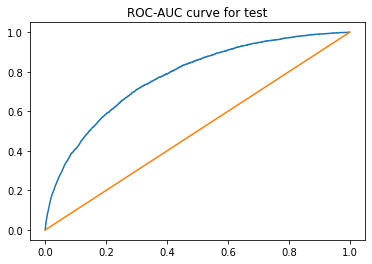

In [21]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.title('ROC-AUC curve for test')
plt.show()

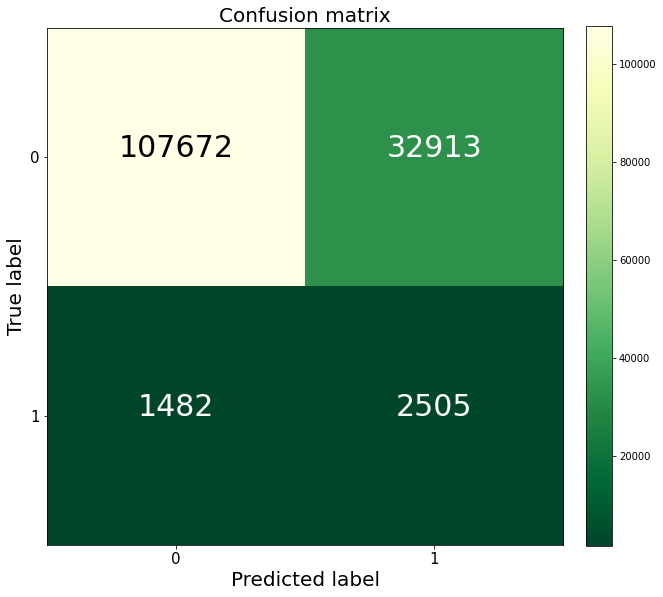

In [28]:
def plot_confusion_matrix(
    y, preds, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.YlGn_r):

    cm = confusion_matrix(y, preds)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig = plt.figure(figsize=(9, 9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black",
                 fontsize=30)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

    plt.show()
    
    
y_predict_target = model.predict(X_test[features])
plot_confusion_matrix(y_test, y_predict_target, classes=[0, 1])

Исходя из ROC-AUC, Confusion Matrix можно применять решение о дальнейшем Feature Engineering, обучние, провдении стат. тестов 

In [17]:
pickle.dump(model, open('lgbm_model.pkl', 'wb'))

Сохраним / сериализируем полученную LGBM модель при помощи `pickle` или `joblib`

#### Feature importances & SHAP Interpretation

Исходя из Feature Importance / Eli5 / SHAP мы можем принимать решение о сокращении фич до нужного числа (при сохранении качества), а также об интерпретации модели.
Видим что частота клиентских транзакций, максимальные суммы транзакций, посещение конкретных магазинов или категорий трат (MCC) наиболее сильно влияют на решение модели о том вернет ли человек займ/кредит

Plotting feature importances...


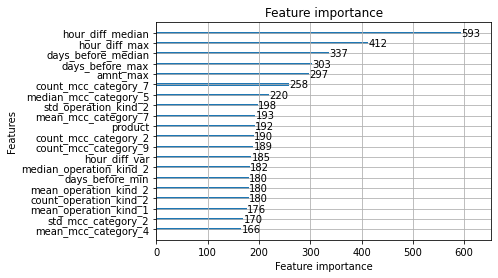

In [18]:
print('Plotting feature importances...')
ax = plot_importance(model, max_num_features=20)
plt.show()

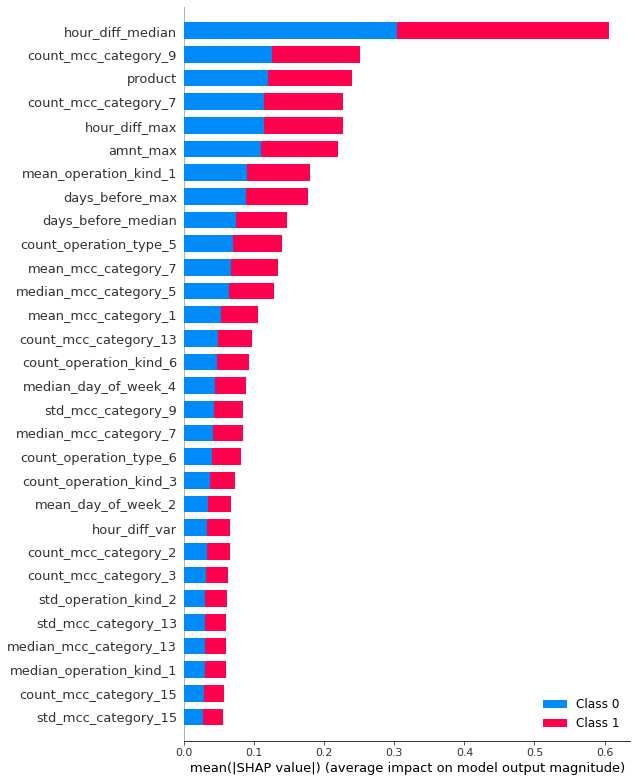

In [22]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test[features])

shap.summary_plot(shap_values, X_test[features], max_display=30, auto_size_plot=True)

Скачаем сэмпл данных, необходимых для демо модели. Более интересным/трудозатратынм решением было бы использование TabularGAN/Autoencoder для сэпмла похожих данных различных классов из этого распределения (базового датасета)

In [36]:
demo_data = pd.concat([train_dataset[train_dataset.flag == 1], train_dataset[train_dataset.flag == 0].sample(n=30000, random_state=41)])
demo_data.shape

(56577, 441)

In [37]:
demo_data.flag.value_counts()

0    30000
1    26577
Name: flag, dtype: int64

In [38]:
demo_data.to_csv('demo_data.csv', index=False)

### Выводы:
- Обученая модель является достаточной для применения с ROC-AUC 0.777 (~0.78)
- Модели на градиентном бустинге являются сильнейшим бейзлайном для скоринга, в какой-то степени интерпретируемы, и не тяжеловесны
- При наличии времени, можно было совместить 2 взвешенные GB модели с весами (пр. LGBM и XGB), что с точки зрения статистики могло бы повысить качество на отложенной выборке, в production, уменьшить риски переобучения
- Есть вариант блендинга/стэкинга нескольких бустинговых моделей
- Также можно сделать блендинг с LSTM-based нейросетью - https://github.com/smirnovevgeny/AlfaBattle2.0/tree/master/rnn_baseline что является SOTA в индустрии банковского кредитного скоринга, также крупные компании используют графы, эмбединги (пр. node2vec), напр. внутрибанковские переводы клиентов между собой, для межбанка есть возможность запрашивать транзакционные данные у Платежных Систем
- Модели скоринга должны работь быстро, так как в день получают тысячи/миллионы запросов по API. Поэтому стремяться в production использовать простые решения, напр. логистическую регрессию. Для поддержания и мониторинга моделей-ансамблей, нейросетей требуется инфраструктура
- Для скоринговых моделей актуален concept/data drift, поэтому модели приходится переодически мониторить, валидировать, переобучать